# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


---
## Step 0: Load The Data

In [1]:
import numpy as np
from random import randint
import pandas as pd
import tensorflow as tf

In [2]:
# Load pickled data
import pickle
import sys
print(sys.version)

training_file = './traffic-signs-data/train.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# Reserve 30% of the available test samples for training sessions
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(train['features'], train['labels'], test_size=0.3, random_state=42)
X_test, y_test = test['features'], test['labels']

3.5.2 | packaged by conda-forge | (default, Jan 19 2017, 15:28:33) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]


---

## Step 1: Dataset Summary & Exploration

### Input Summary

In [3]:
### Replace each question mark with the appropriate value.

n_train = X_train.shape[0]
n_test = X_test.shape[0]
n_valid = X_validation.shape[0]
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_valid)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 24359
Number of testing examples = 12630
Number of validation examples = 10440
Image data shape = (32, 32, 3)
Number of classes = 43


### Verify Dataset against Labels

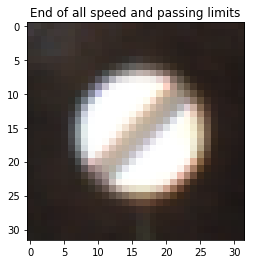

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# Load corresponding sign-names for the labels
SignNames = pd.read_csv('./signnames.csv')

# Display random images from the input dataset
idx = randint(0,len(X_train) - 1)
plt.imshow(X_train[idx])

# Identify picture sign-names
SignName = SignNames[SignNames['ClassId'] == y_train[idx]]['SignName'].values[0]
plt.title(SignName)

<Container object of 43 artists>

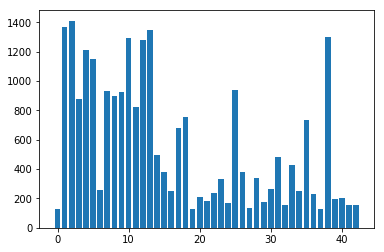

In [5]:
# Its common to have different number of input samples for every label
unique, unique_counts = np.unique(y_train, return_counts=True)
plt.bar(unique, unique_counts)

---
## Step 2: Dataset Augmentation

Dataset augmentation is very essential to improve performance of the Perceptron (Classification step) in a neural network. Apparently data augmentation in data-space is much performant that augmentation in feature-space [1].
```
REFERENCE
1) Understanding data augmentation for classification: when to warp?. Site: https://arxiv.org/pdf/1609.08764.pdf
```

In [6]:
## Generate more image samples by rotating, shearing, translating, augmenting brightness of a picture
## This code is stolen from Vivek Yadav, because I'm lazy ;p
## Link: https://github.com/vxy10/ImageAugmentation
import matplotlib.gridspec as gridspec
import cv2
import matplotlib.image as mpimg

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img, ang_range=20, shear_range=10, trans_range=5, brightness=1):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    
    ang_range: Range of angles for rotation
    shear_range: Range of values to apply affine transform to
    trans_range: Range of values to apply translations over.
    brightness: Flag for brigtness updates

    '''
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    # Brightness
    if brightness == 1:
      img = augment_brightness_camera_images(img)

    return img

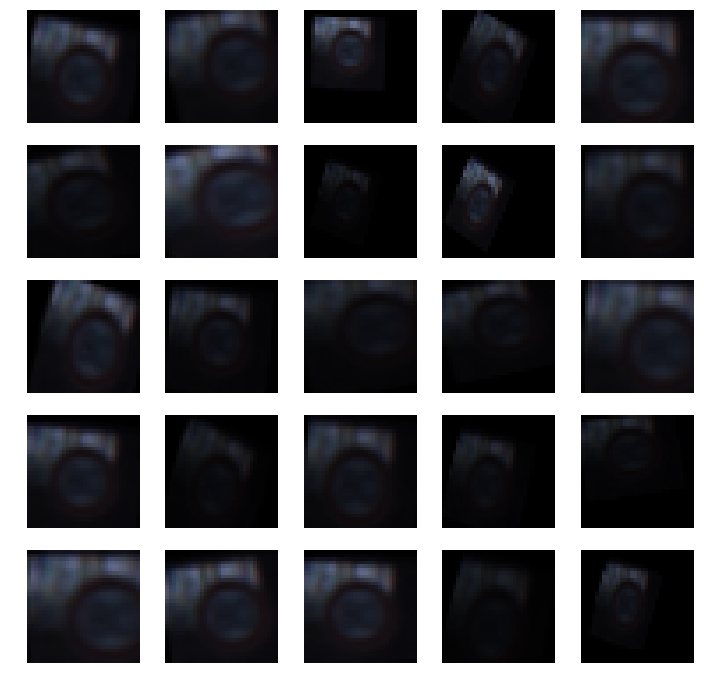

In [7]:
## examine the results
gs1 = gridspec.GridSpec(5, 5)
gs1.update(wspace=0.005, hspace=0.01) # set the spacing between axes.
plt.figure(figsize=(12,12))
for i in range(25):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    img = transform_image(X_train[0])

    plt.subplot(5,5,i+1)
    plt.imshow(img)
    plt.axis('off')

In [8]:
## create jittered images, fill each lable with 5000 samples for training
from sklearn.utils import resample
traget_samples = 5000
for label, count in enumerate(unique_counts):
    to_be_generated = traget_samples - count
    
    X_sample, y_sample = resample(X_train[y_train == label], y_train[y_train == label], n_samples=to_be_generated, random_state=42)

    X_jittered = np.zeros_like(X_sample)
    # apply transform on each image
    for idx, image in enumerate(X_sample):
        X_jittered[idx] = transform_image(image)
        
    X_train = np.concatenate((X_train,X_jittered))
    y_train = np.concatenate((y_train, y_sample))


print(X_train.shape)
print(y_train.shape)

(215000, 32, 32, 3)
(215000,)


133269


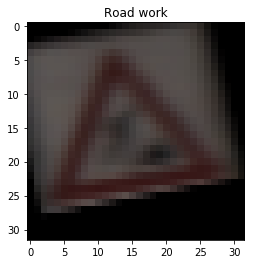

In [9]:
# visualize sythetic pictures
idx = randint(n_train,len(X_train) - 1)
print(idx)
plt.imshow(X_train[idx])
# show sign name
SignName = SignNames[SignNames['ClassId'] == y_train[idx]]['SignName'].values[0]
plt.title(SignName)

In [10]:
# shuffle training set
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)

<Container object of 43 artists>

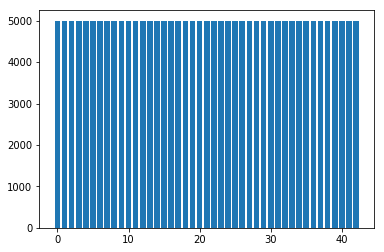

In [11]:
# test if label distribution balanced now
unique, unique_counts = np.unique(y_train, return_counts=True)
plt.bar(unique, unique_counts)

In [12]:
## preprocessing: turn color image to black and white
## idea stolen from Yann lecun
## code stolen from http://navoshta.com/traffic-signs-classification/
import warnings
from skimage import exposure

# Print iterations progress
def print_progress(iteration, total):
    """
    Call in a loop to create terminal progress bar
    
    Parameters
    ----------
        
    iteration : 
                Current iteration (Int)
    total     : 
                Total iterations (Int)
    """
    str_format = "{0:.0f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(100 * iteration / float(total)))
    bar = '█' * filled_length + '-' * (100 - filled_length)

    sys.stdout.write('\r |%s| %s%%' % (bar, percents)),

    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()
    
def gray_scale(X):
    #Convert to grayscale, e.g. single Y channel
    X = 0.299 * X[:, :, :, 0] + 0.587 * X[:, :, :, 1] + 0.114 * X[:, :, :, 2]
    #Scale features to be in [0, 1]
    X = (X / 255.).astype(np.float32)

    # Apply localized histogram localization
    for i in range(X.shape[0]):
        # X[i] = exposure.equalize_adapthist(X[i])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X[i] = exposure.equalize_adapthist(X[i])
        print_progress(i + 1, X.shape[0])
        
    # Add a single grayscale channel
    X = X.reshape(X.shape + (1,)) 
    return X


# import warnings

# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")

X_train = gray_scale(X_train)
X_validation = gray_scale(X_validation)
X_test = gray_scale(X_test)

print(X_test.shape)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
(12630, 32, 32, 1)


187512


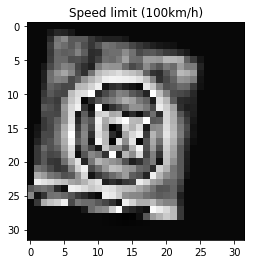

In [13]:
## show gray scale image
idx = randint(n_train,len(X_train) - 1)
print(idx)
plt.imshow(X_train[idx].squeeze(), cmap='gray')
# show sign name
SignName = SignNames[SignNames['ClassId'] == y_train[idx]]['SignName'].values[0]
plt.title(SignName)

----
## Step 3: Design and Test a Model Architecture

### Implementation

Below is an exact implementation of Yan LeCun's NN-model from https://github.com/udacity/CarND-LeNet-Lab/blob/master/LeNet-Lab-Solution.ipynb

In [14]:
### Shuffle data
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [15]:
from tensorflow.contrib.layers import flatten

# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.1
conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 32), mean = mu, stddev = sigma))
conv1_b = tf.Variable(tf.zeros(32))
conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean = mu, stddev = sigma))
conv2_b = tf.Variable(tf.zeros(64))
fc1_W = tf.Variable(tf.truncated_normal(shape=(7872, 1024), mean = mu, stddev = sigma))
fc1_b = tf.Variable(tf.zeros(1024))
fc2_W  = tf.Variable(tf.truncated_normal(shape=(1024, 1024), mean = mu, stddev = sigma))
fc2_b  = tf.Variable(tf.zeros(1024))
fc3_W  = tf.Variable(tf.truncated_normal(shape=(1024, 43), mean = mu, stddev = sigma))
fc3_b  = tf.Variable(tf.zeros(43))

def LeNet(x):    
    
    # SOLUTION: Layer 1: Convolutional. input 32,32,1, output 28,28,32
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. input 28,28,32, output 14, 14, 32
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Dropout
    tf.nn.dropout(pool1, .5)
    
    # SOLUTION: Layer 2: Convolutional. input 14,14,32, output 10, 10, 64
    conv2   = tf.nn.conv2d(pool1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. input 10, 10, 64, output 5,5,64
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Dropout
    tf.nn.dropout(pool2, .5)
    # SOLUTION: Flatten. input 5,5,64 + 14,14,32, output 1600 + 6272 = 7872
    fc0   = tf.concat(1, [flatten(pool2), flatten(pool1)])
    # Relu
    tf.nn.relu(fc0)
    # Dropout
    tf.nn.dropout(fc0, .5)
    
    # SOLUTION: Layer 3: Fully Connected. input 7872, output 1024
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    # Dropout
    tf.nn.dropout(fc1, .5)
    
    # SOLUTION: Layer 4: Fully Connected. input 1024, output 1024
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    # Dropout
    tf.nn.dropout(fc2, .5)
    
    # SOLUTION: Layer 5: Fully Connected. input 1024, output 43
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    # Dropout
    tf.nn.dropout(logits, .5) 
    
    return logits

#### Training with AdamOptimizer


In [16]:
### Training

EPOCHS = 10
BATCH_SIZE = 128

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

rate = 1e-4
lamda = 1e-5

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
## L2 regularization for weights
l2_loss = lamda * (tf.nn.l2_loss(conv1_W) + tf.nn.l2_loss(conv2_W) + tf.nn.l2_loss(fc1_W) + tf.nn.l2_loss(fc2_W) + tf.nn.l2_loss(fc3_W))
loss_operation = tf.reduce_mean(cross_entropy + l2_loss)

optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    train_acc_list = []
    validation_acc_list = []
    

    max_accuracy = .0
    non_improve_counter = 0
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        mini_batch_accuracy = evaluate(batch_x, batch_y)
        validation_accuracy = evaluate(X_validation, y_validation)

        train_acc_list.append(mini_batch_accuracy)
        validation_acc_list.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Training accuracy = {:.3f}, Validation Accuracy = {:.3f}".format(mini_batch_accuracy, validation_accuracy))
        print()
        
        if validation_accuracy > max_accuracy:
            max_accuracy = validation_accuracy
            non_improve_counter = 0
        else:
            non_improve_counter += 1
        
        # early stop if accuracy does not improve in 10 epochs
        if non_improve_counter > 1:
            print("Early stop at epoch {}".format(i))
            break
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Training accuracy = 0.625, Validation Accuracy = 0.885

EPOCH 2 ...
Training accuracy = 0.841, Validation Accuracy = 0.949

EPOCH 3 ...
Training accuracy = 0.795, Validation Accuracy = 0.962

EPOCH 4 ...
Training accuracy = 0.875, Validation Accuracy = 0.973

EPOCH 5 ...
Training accuracy = 0.920, Validation Accuracy = 0.973

EPOCH 6 ...
Training accuracy = 0.977, Validation Accuracy = 0.977

EPOCH 7 ...
Training accuracy = 0.955, Validation Accuracy = 0.980

EPOCH 8 ...
Training accuracy = 0.989, Validation Accuracy = 0.984

EPOCH 9 ...
Training accuracy = 1.000, Validation Accuracy = 0.986

EPOCH 10 ...
Training accuracy = 1.000, Validation Accuracy = 0.988

Model saved


In [17]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('./lenet.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.927


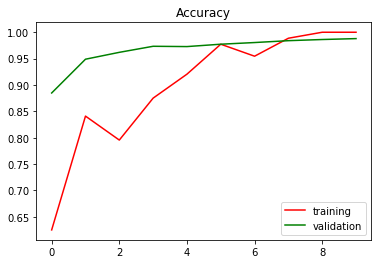

In [18]:
plt.plot(np.arange(len(train_acc_list)), train_acc_list, 'r', np.arange(len(validation_acc_list)), validation_acc_list, 'g')
plt.title("Accuracy")
plt.legend(['training', 'validation'])